# Lab-1.5: 性能深度分析
## Performance Analysis - Deep Dive into FlashAttention

**學習目標**:
- 使用 PyTorch Profiler 深入分析 FlashAttention
- 理解記憶體訪問模式與性能瓶頸
- 優化不同場景的超參數配置
- 建立性能預測模型

**預計時間**: 45-60分鐘

## 1. 環境設置

In [10]:
import torch
import torch.nn as nn
from torch.profiler import profile, ProfilerActivity, record_function
from torch.cuda.amp import autocast
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import gc


# 設定 matplotlib 支援繁體中文字體，嘗試自動偵測常見中文字體
import matplotlib
from matplotlib import font_manager

# 常見繁體中文字體清單（可視實際情況增減）
chinese_fonts = [
    "Noto Sans CJK JP", #
]
font_found = False

for font_name in chinese_fonts:
    if any(font_name in f.name for f in font_manager.fontManager.ttflist):
        plt.rcParams['font.family'] = font_name
        font_found = True
        print(f"✅ Matplotlib 已使用中文字體: {font_name}")
        break

if not font_found:
    print("⚠️ 未找到系統內建常見繁體中文字體，建議安裝 Noto Sans TC 或 Microsoft JhengHei 以獲得最佳效果。")

# 解決負號無法正常顯示的問題
plt.rcParams['axes.unicode_minus'] = False

# FlashAttention
try:
    from flash_attn import flash_attn_func
    FLASH_ATTN_AVAILABLE = True
    print("✅ FlashAttention 可用")
except ImportError:
    FLASH_ATTN_AVAILABLE = False
    print("❌ FlashAttention 未安裝")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n使用設備: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    capability = torch.cuda.get_device_capability()
    print(f"Compute Capability: {capability[0]}.{capability[1]}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Matplotlib 已使用中文字體: Noto Sans CJK JP
✅ FlashAttention 可用

使用設備: cuda
GPU: NVIDIA RTX 2000 Ada Generation
Compute Capability: 8.9
VRAM: 16.71 GB


## 2. Profiler 工具設置

In [11]:
def profile_attention(attn_func, Q, K, V, name="Attention", num_iters=10):
    """
    使用 PyTorch Profiler 分析 attention 性能
    
    Args:
        attn_func: attention 函數
        Q, K, V: 輸入張量
        name: 函數名稱
        num_iters: 測試次數
    """
    # 預熱
    for _ in range(3):
        _ = attn_func(Q, K, V)
    
    # Profiling
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        profile_memory=True,
        with_flops=True
    ) as prof:
        with record_function(name):
            for _ in range(num_iters):
                _ = attn_func(Q, K, V)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
    
    return prof


def print_profiler_summary(prof, sort_by="cuda_time_total", row_limit=10):
    """打印 Profiler 摘要"""
    print("\n" + "="*80)
    print(f"Profiler 摘要 (排序: {sort_by}, 前 {row_limit} 項)")
    print("="*80)
    
    # 嘗試不同的排序鍵，以兼容不同版本的 PyTorch
    available_sort_keys = ["cuda_time_total", "device_time_total", "self_cuda_time_total", "self_device_time_total"]
    
    used_sort_key = sort_by
    for key in available_sort_keys:
        try:
            # 測試是否支持這個排序鍵
            table = prof.key_averages().table(sort_by=key, row_limit=1)
            used_sort_key = key
            break
        except (AttributeError, KeyError):
            continue
    
    try:
        print(prof.key_averages().table(
            sort_by=used_sort_key,
            row_limit=row_limit
        ))
    except Exception as e:
        print(f"⚠️  無法顯示詳細表格: {e}")
        print("基本統計:")
        events = prof.key_averages()
        print(f"  總事件數: {len(events)}")
        for i, evt in enumerate(events[:5]):
            print(f"  {i+1}. {evt.key}")


print("✅ Profiler 工具準備完成")

✅ Profiler 工具準備完成


## 3. 標準 Attention 性能分析

In [12]:
import math

def standard_attention(Q, K, V):
    """標準 Self-Attention 實現"""
    # Q, K, V: [batch, seq_len, num_heads, head_dim]
    d_k = Q.size(-1)
    
    # 轉換為 [batch, num_heads, seq_len, head_dim]
    Q = Q.transpose(1, 2)
    K = K.transpose(1, 2)
    V = V.transpose(1, 2)
    
    # Attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    attn_weights = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    
    # 轉回 [batch, seq_len, num_heads, head_dim]
    output = output.transpose(1, 2)
    
    return output


print("="*70)
print("標準 Attention 性能分析")
print("="*70)

# 測試配置
batch_size, seq_len, num_heads, head_dim = 4, 512, 12, 64

Q = torch.randn(batch_size, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
K = torch.randn(batch_size, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
V = torch.randn(batch_size, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)

print(f"\n測試配置:")
print(f"  Batch Size: {batch_size}")
print(f"  Sequence Length: {seq_len}")
print(f"  Num Heads: {num_heads}")
print(f"  Head Dim: {head_dim}")

# Profile 標準 Attention
prof_std = profile_attention(
    standard_attention,
    Q, K, V,
    name="Standard_Attention",
    num_iters=10
)

print_profiler_summary(prof_std, sort_by="cuda_time_total", row_limit=15)

標準 Attention 性能分析

測試配置:
  Batch Size: 4
  Sequence Length: 512
  Num Heads: 12
  Head Dim: 64

Profiler 摘要 (排序: cuda_time_total, 前 15 項)
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total GFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     Standard_Attention 

## 4. FlashAttention 性能分析

In [13]:
if FLASH_ATTN_AVAILABLE:
    print("="*70)
    print("FlashAttention 性能分析")
    print("="*70)
    
    def flash_attention_wrapper(Q, K, V):
        """FlashAttention 包裝 (匹配標準格式)"""
        return flash_attn_func(Q, K, V, causal=False)
    
    # Profile FlashAttention
    prof_flash = profile_attention(
        flash_attention_wrapper,
        Q, K, V,
        name="FlashAttention",
        num_iters=10
    )
    
    print_profiler_summary(prof_flash, sort_by="cuda_time_total", row_limit=15)
    
    # 對比分析
    print("\n" + "="*70)
    print("性能對比")
    print("="*70)
    
    std_events = prof_std.key_averages()
    flash_events = prof_flash.key_averages()
    
    # 兼容不同版本的 PyTorch profiler API
    def get_cuda_time(events):
        total_time = 0
        for evt in events:
            # 嘗試不同的屬性名
            if hasattr(evt, 'cuda_time_total'):
                total_time += evt.cuda_time_total
            elif hasattr(evt, 'device_time_total'):
                total_time += evt.device_time_total
            elif hasattr(evt, 'self_cuda_time_total'):
                total_time += evt.self_cuda_time_total
            elif hasattr(evt, 'self_device_time_total'):
                total_time += evt.self_device_time_total
        return total_time
    
    std_cuda_time = get_cuda_time(std_events)
    flash_cuda_time = get_cuda_time(flash_events)
    
    print(f"\n標準 Attention CUDA 時間: {std_cuda_time / 1e3:.2f} ms")
    print(f"FlashAttention CUDA 時間: {flash_cuda_time / 1e3:.2f} ms")
    
    if flash_cuda_time > 0:
        print(f"\n⚡ 加速比: {std_cuda_time / flash_cuda_time:.2f}x")
    else:
        print(f"\n⚠️  無法計算加速比 (FlashAttention 時間為 0)")
    
else:
    print("\n⚠️  FlashAttention 未安裝, 跳過性能分析")

FlashAttention 性能分析

Profiler 摘要 (排序: cuda_time_total, 前 15 項)
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         FlashAttention         0.00%       0.000us         0.00%       0.000us       0.000us     994.069us       145.68%     994.069us     9

## 5. 記憶體訪問模式分析

In [14]:
def analyze_memory_pattern(prof, name="Model"):
    """分析記憶體訪問模式"""
    print("\n" + "="*70)
    print(f"{name} 記憶體分析")
    print("="*70)
    
    events = prof.key_averages()
    
    # 兼容不同版本的 PyTorch profiler API
    def get_memory_usage(evt):
        cpu_mem = 0
        cuda_mem = 0
        
        # 嘗試不同的屬性名
        if hasattr(evt, 'cpu_memory_usage'):
            cpu_mem = evt.cpu_memory_usage
        elif hasattr(evt, 'self_cpu_memory_usage'):
            cpu_mem = evt.self_cpu_memory_usage
            
        if hasattr(evt, 'cuda_memory_usage'):
            cuda_mem = evt.cuda_memory_usage
        elif hasattr(evt, 'self_cuda_memory_usage'):
            cuda_mem = evt.self_cuda_memory_usage
        elif hasattr(evt, 'device_memory_usage'):
            cuda_mem = evt.device_memory_usage
        elif hasattr(evt, 'self_device_memory_usage'):
            cuda_mem = evt.self_device_memory_usage
            
        return cpu_mem, cuda_mem
    
    # 按記憶體使用排序
    memory_events = []
    for evt in events:
        cpu_mem, cuda_mem = get_memory_usage(evt)
        if cpu_mem > 0 or cuda_mem > 0:
            memory_events.append((evt, cpu_mem, cuda_mem))
    
    # 按 CUDA 記憶體使用排序
    memory_events.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"\n{'操作':<40} {'CPU記憶體(MB)':<18} {'CUDA記憶體(MB)':<18}")
    print("-"*76)
    
    for evt, cpu_mem, cuda_mem in memory_events[:10]:
        cpu_mem_mb = cpu_mem / 1e6
        cuda_mem_mb = cuda_mem / 1e6
        print(f"{evt.key[:38]:<40} {cpu_mem_mb:>15.2f} {cuda_mem_mb:>15.2f}")


# 分析標準 Attention 記憶體
analyze_memory_pattern(prof_std, "標準 Attention")

# 分析 FlashAttention 記憶體
if FLASH_ATTN_AVAILABLE:
    analyze_memory_pattern(prof_flash, "FlashAttention")


標準 Attention 記憶體分析

操作                                       CPU記憶體(MB)         CUDA記憶體(MB)       
----------------------------------------------------------------------------
aten::matmul                                        0.00          301.99
aten::bmm                                           0.00          283.12
aten::div                                           0.00          251.66
aten::softmax                                       0.00          251.66
aten::_softmax                                      0.00          251.66
aten::reshape                                       0.00           94.37
aten::clone                                         0.00           94.37
aten::empty_like                                    0.00           94.37
aten::empty                                         0.00           94.37

FlashAttention 記憶體分析

操作                                       CPU記憶體(MB)         CUDA記憶體(MB)       
----------------------------------------------------------------

## 6. 不同序列長度的性能縮放分析

In [15]:
if FLASH_ATTN_AVAILABLE:
    print("="*70)
    print("序列長度縮放分析")
    print("="*70)
    
    seq_lengths = [256, 512, 1024, 2048]
    batch_size = 4
    num_heads = 12
    head_dim = 64
    num_iters = 20
    
    results = {
        "seq_len": [],
        "std_time": [],
        "flash_time": [],
        "std_memory": [],
        "flash_memory": []
    }
    
    for seq_len in tqdm(seq_lengths, desc="測試不同序列長度"):
        print(f"\n測試序列長度: {seq_len}")
        
        Q = torch.randn(batch_size, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
        K = torch.randn(batch_size, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
        V = torch.randn(batch_size, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
        
        results["seq_len"].append(seq_len)
        
        # 標準 Attention
        try:
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.empty_cache()
            
            times = []
            for _ in range(num_iters):
                start = time.time()
                _ = standard_attention(Q, K, V)
                torch.cuda.synchronize()
                times.append(time.time() - start)
            
            std_time = np.mean(times) * 1000  # ms
            std_mem = torch.cuda.max_memory_allocated() / 1e9  # GB
            
            results["std_time"].append(std_time)
            results["std_memory"].append(std_mem)
            
            print(f"  標準: {std_time:.2f}ms, {std_mem:.2f}GB")
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                results["std_time"].append(None)
                results["std_memory"].append(None)
                print(f"  標準: OOM")
            else:
                raise e
        
        # FlashAttention
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        
        times = []
        for _ in range(num_iters):
            start = time.time()
            _ = flash_attn_func(Q, K, V, causal=False)
            torch.cuda.synchronize()
            times.append(time.time() - start)
        
        flash_time = np.mean(times) * 1000  # ms
        flash_mem = torch.cuda.max_memory_allocated() / 1e9  # GB
        
        results["flash_time"].append(flash_time)
        results["flash_memory"].append(flash_mem)
        
        print(f"  Flash: {flash_time:.2f}ms, {flash_mem:.2f}GB")
    
    # 轉換為 DataFrame
    df = pd.DataFrame(results)
    
    print("\n" + "="*70)
    print("縮放性能表")
    print("="*70)
    print(df.to_string(index=False))
    
else:
    print("⚠️  FlashAttention 未安裝, 跳過縮放分析")

序列長度縮放分析


測試不同序列長度:   0%|          | 0/4 [00:00<?, ?it/s]


測試序列長度: 256
  標準: 0.15ms, 0.04GB
  Flash: 0.17ms, 0.01GB

測試序列長度: 512
  標準: 0.91ms, 0.07GB
  Flash: 0.23ms, 0.02GB

測試序列長度: 1024
  標準: 3.34ms, 0.24GB
  Flash: 0.49ms, 0.03GB

測試序列長度: 2048
  標準: 12.54ms, 0.88GB
  Flash: 1.41ms, 0.06GB

縮放性能表
 seq_len  std_time  flash_time  std_memory  flash_memory
     256  0.154507    0.174415    0.038404      0.014861
     512  0.905824    0.233543    0.074580      0.021201
    1024  3.335559    0.487518    0.241304      0.033883
    2048 12.541807    1.413417    0.876741      0.059245


## 7. 性能縮放視覺化

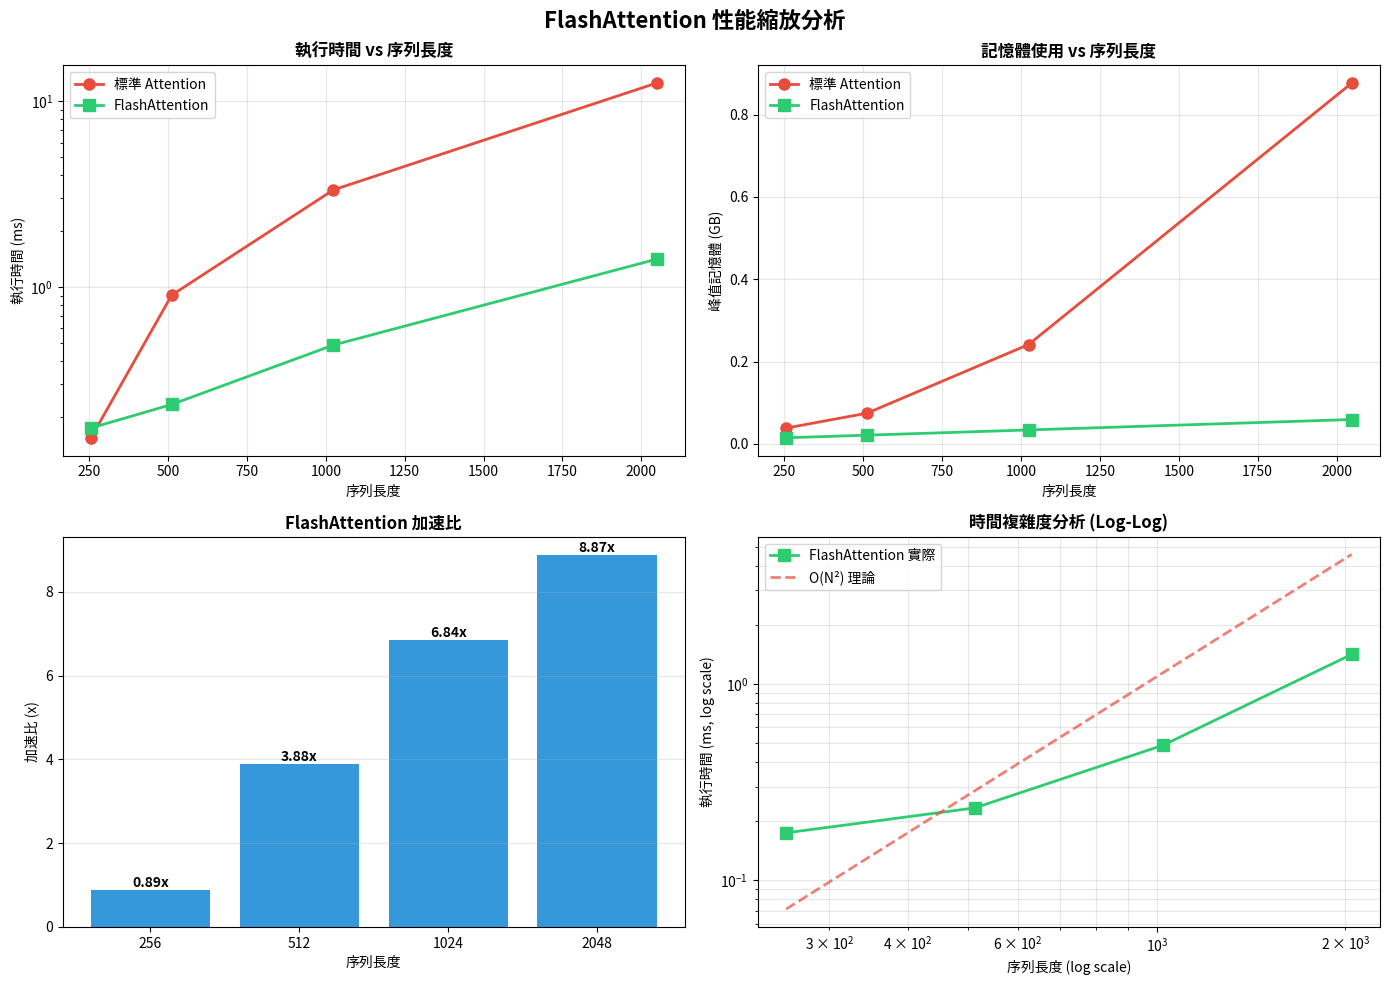

In [16]:
if FLASH_ATTN_AVAILABLE and 'results' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("FlashAttention 性能縮放分析", fontsize=16, fontweight='bold')
    
    seq_lens = results["seq_len"]
    
    # 1. 執行時間縮放
    std_times = [t for t in results["std_time"] if t is not None]
    flash_times = results["flash_time"]
    valid_seq_lens = seq_lens[:len(std_times)]
    
    axes[0, 0].plot(valid_seq_lens, std_times, 'o-', linewidth=2, markersize=8, label='標準 Attention', color='#e74c3c')
    axes[0, 0].plot(seq_lens, flash_times, 's-', linewidth=2, markersize=8, label='FlashAttention', color='#2ecc71')
    axes[0, 0].set_xlabel('序列長度')
    axes[0, 0].set_ylabel('執行時間 (ms)')
    axes[0, 0].set_title('執行時間 vs 序列長度', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # 2. 記憶體縮放
    std_mems = [m for m in results["std_memory"] if m is not None]
    flash_mems = results["flash_memory"]
    
    axes[0, 1].plot(valid_seq_lens, std_mems, 'o-', linewidth=2, markersize=8, label='標準 Attention', color='#e74c3c')
    axes[0, 1].plot(seq_lens, flash_mems, 's-', linewidth=2, markersize=8, label='FlashAttention', color='#2ecc71')
    axes[0, 1].set_xlabel('序列長度')
    axes[0, 1].set_ylabel('峰值記憶體 (GB)')
    axes[0, 1].set_title('記憶體使用 vs 序列長度', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. 加速比
    speedups = [std_times[i] / flash_times[i] for i in range(len(std_times))]
    axes[1, 0].bar(range(len(valid_seq_lens)), speedups, color='#3498db')
    axes[1, 0].set_xticks(range(len(valid_seq_lens)))
    axes[1, 0].set_xticklabels([str(sl) for sl in valid_seq_lens])
    axes[1, 0].set_xlabel('序列長度')
    axes[1, 0].set_ylabel('加速比 (x)')
    axes[1, 0].set_title('FlashAttention 加速比', fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 添加數值標籤
    for i, v in enumerate(speedups):
        axes[1, 0].text(i, v, f'{v:.2f}x', ha='center', va='bottom', fontweight='bold')
    
    # 4. 複雜度分析 (Log-Log plot)
    axes[1, 1].loglog(seq_lens, flash_times, 's-', linewidth=2, markersize=8, label='FlashAttention 實際', color='#2ecc71')
    
    # 擬合 O(N²) 曲線
    seq_lens_arr = np.array(seq_lens)
    flash_times_arr = np.array(flash_times)
    
    # y = a*N^2
    a = np.mean(flash_times_arr / (seq_lens_arr ** 2))
    theoretical = a * (seq_lens_arr ** 2)
    
    axes[1, 1].loglog(seq_lens, theoretical, '--', linewidth=2, label='O(N²) 理論', color='#e74c3c', alpha=0.7)
    axes[1, 1].set_xlabel('序列長度 (log scale)')
    axes[1, 1].set_ylabel('執行時間 (ms, log scale)')
    axes[1, 1].set_title('時間複雜度分析 (Log-Log)', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  無法繪製圖表 - FlashAttention 未安裝或無測試結果")

## 8. 批次大小影響分析

批次大小影響分析


測試不同批次大小:   0%|          | 0/5 [00:00<?, ?it/s]

  Batch=1: 0.25ms, 0.03GB, 4095516 tokens/s
  Batch=2: 0.31ms, 0.02GB, 6572756 tokens/s
  Batch=4: 0.49ms, 0.03GB, 8407698 tokens/s
  Batch=8: 0.82ms, 0.06GB, 9931852 tokens/s
  Batch=16: 1.52ms, 0.11GB, 10811664 tokens/s


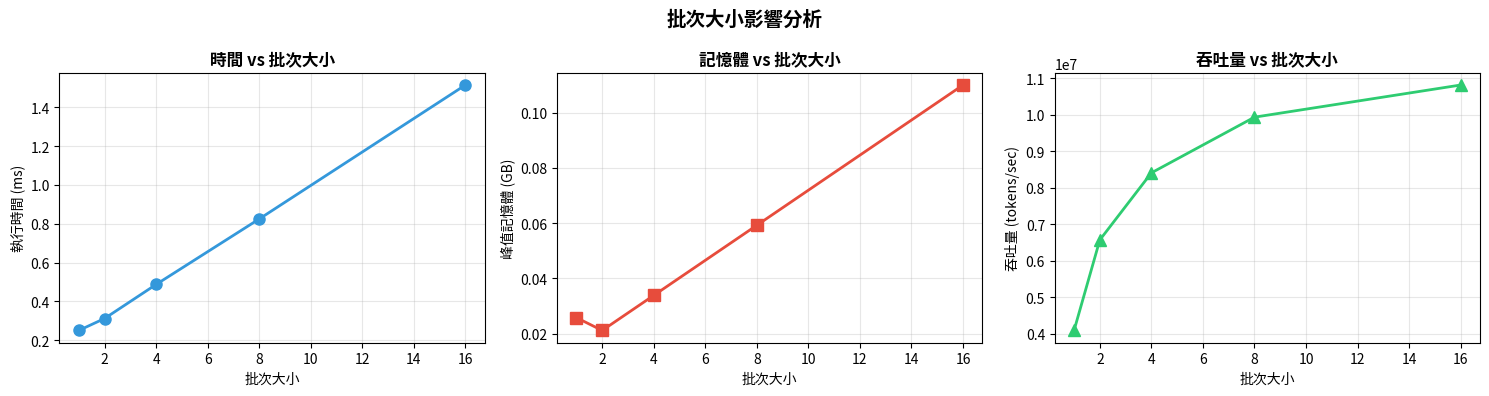

In [17]:
if FLASH_ATTN_AVAILABLE:
    print("="*70)
    print("批次大小影響分析")
    print("="*70)
    
    seq_len = 1024
    num_heads = 12
    head_dim = 64
    batch_sizes = [1, 2, 4, 8, 16]
    
    batch_results = {
        "batch_size": [],
        "time_ms": [],
        "memory_gb": [],
        "throughput": []  # tokens/sec
    }
    
    for bs in tqdm(batch_sizes, desc="測試不同批次大小"):
        try:
            Q = torch.randn(bs, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
            K = torch.randn(bs, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
            V = torch.randn(bs, seq_len, num_heads, head_dim, device=device, dtype=torch.float16)
            
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.empty_cache()
            
            # 測試時間
            times = []
            for _ in range(20):
                start = time.time()
                _ = flash_attn_func(Q, K, V, causal=False)
                torch.cuda.synchronize()
                times.append(time.time() - start)
            
            avg_time = np.mean(times) * 1000  # ms
            peak_mem = torch.cuda.max_memory_allocated() / 1e9  # GB
            throughput = (bs * seq_len) / (avg_time / 1000)  # tokens/sec
            
            batch_results["batch_size"].append(bs)
            batch_results["time_ms"].append(avg_time)
            batch_results["memory_gb"].append(peak_mem)
            batch_results["throughput"].append(throughput)
            
            print(f"  Batch={bs}: {avg_time:.2f}ms, {peak_mem:.2f}GB, {throughput:.0f} tokens/s")
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"  Batch={bs}: OOM")
                break
            else:
                raise e
    
    # 視覺化
    if batch_results["batch_size"]:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle("批次大小影響分析", fontsize=14, fontweight='bold')
        
        bs_list = batch_results["batch_size"]
        
        # 時間
        axes[0].plot(bs_list, batch_results["time_ms"], 'o-', linewidth=2, markersize=8, color='#3498db')
        axes[0].set_xlabel('批次大小')
        axes[0].set_ylabel('執行時間 (ms)')
        axes[0].set_title('時間 vs 批次大小', fontweight='bold')
        axes[0].grid(alpha=0.3)
        
        # 記憶體
        axes[1].plot(bs_list, batch_results["memory_gb"], 's-', linewidth=2, markersize=8, color='#e74c3c')
        axes[1].set_xlabel('批次大小')
        axes[1].set_ylabel('峰值記憶體 (GB)')
        axes[1].set_title('記憶體 vs 批次大小', fontweight='bold')
        axes[1].grid(alpha=0.3)
        
        # 吞吐量
        axes[2].plot(bs_list, batch_results["throughput"], '^-', linewidth=2, markersize=8, color='#2ecc71')
        axes[2].set_xlabel('批次大小')
        axes[2].set_ylabel('吞吐量 (tokens/sec)')
        axes[2].set_title('吞吐量 vs 批次大小', fontweight='bold')
        axes[2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

else:
    print("⚠️  FlashAttention 未安裝, 跳過批次大小分析")

## 9. 最佳配置建議生成器

In [18]:
def generate_optimal_config(gpu_memory_gb, seq_length, model_size="medium"):
    """
    根據硬體配置生成最佳訓練配置
    
    Args:
        gpu_memory_gb: GPU 記憶體 (GB)
        seq_length: 目標序列長度
        model_size: 模型大小 (small, medium, large)
    """
    print("="*70)
    print("FlashAttention 最佳配置建議")
    print("="*70)
    
    print(f"\n輸入配置:")
    print(f"  GPU 記憶體: {gpu_memory_gb} GB")
    print(f"  序列長度: {seq_length}")
    print(f"  模型大小: {model_size}")
    
    # 基於序列長度推薦批次大小
    if seq_length <= 512:
        recommended_bs = min(16, int(gpu_memory_gb // 2))
    elif seq_length <= 1024:
        recommended_bs = min(8, int(gpu_memory_gb // 3))
    elif seq_length <= 2048:
        recommended_bs = min(4, int(gpu_memory_gb // 4))
    elif seq_length <= 4096:
        recommended_bs = min(2, int(gpu_memory_gb // 8))
    else:
        recommended_bs = 1
    
    # 梯度累積建議
    effective_bs = 32  # 目標有效批次
    accumulation_steps = max(1, effective_bs // recommended_bs)
    
    # 其他優化建議
    use_amp = True
    use_grad_checkpoint = seq_length > 1024 or model_size == "large"
    use_flash_attn = True
    
    print("\n" + "="*70)
    print("推薦配置")
    print("="*70)
    
    print(f"\n核心配置:")
    print(f"  批次大小: {recommended_bs}")
    print(f"  梯度累積步數: {accumulation_steps}")
    print(f"  有效批次大小: {recommended_bs * accumulation_steps}")
    
    print(f"\n優化技術:")
    print(f"  混合精度訓練: {'✅ 啟用' if use_amp else '❌ 關閉'}")
    print(f"  梯度檢查點: {'✅ 啟用' if use_grad_checkpoint else '❌ 關閉'}")
    print(f"  FlashAttention: {'✅ 啟用' if use_flash_attn else '❌ 關閉'}")
    
    # 代碼範例
    print("\n" + "="*70)
    print("配置代碼範例")
    print("="*70)
    
    code = f"""
# 訓練配置
config = {{
    'batch_size': {recommended_bs},
    'accumulation_steps': {accumulation_steps},
    'seq_length': {seq_length},
    'use_amp': {use_amp},
    'use_grad_checkpoint': {use_grad_checkpoint},
}}

# 模型配置
model = create_model(seq_length={seq_length})
if config['use_grad_checkpoint']:
    model.gradient_checkpointing_enable()

# 訓練循環
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = GradScaler() if config['use_amp'] else None

for step, batch in enumerate(dataloader):
    if step % config['accumulation_steps'] == 0:
        optimizer.zero_grad()
    
    if config['use_amp']:
        with autocast(dtype=torch.float16):
            loss = model(**batch).loss / config['accumulation_steps']
        scaler.scale(loss).backward()
    else:
        loss = model(**batch).loss / config['accumulation_steps']
        loss.backward()
    
    if (step + 1) % config['accumulation_steps'] == 0:
        if config['use_amp']:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
"""
    print(code)
    
    # 預期性能
    print("\n" + "="*70)
    print("預期性能")
    print("="*70)
    
    if seq_length <= 1024:
        speedup_range = "2-3x"
        memory_saving = "30-40%"
    elif seq_length <= 2048:
        speedup_range = "3-5x"
        memory_saving = "40-50%"
    else:
        speedup_range = "5-8x"
        memory_saving = "50-70%"
    
    print(f"\n相對於標準 Attention:")
    print(f"  速度提升: {speedup_range}")
    print(f"  記憶體節省: {memory_saving}")


# 示例使用
if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    generate_optimal_config(gpu_mem, seq_length=2048, model_size="medium")
else:
    print("示例配置:")
    generate_optimal_config(16, seq_length=2048, model_size="medium")

FlashAttention 最佳配置建議

輸入配置:
  GPU 記憶體: 16.71364608 GB
  序列長度: 2048
  模型大小: medium

推薦配置

核心配置:
  批次大小: 4
  梯度累積步數: 8
  有效批次大小: 32

優化技術:
  混合精度訓練: ✅ 啟用
  梯度檢查點: ✅ 啟用
  FlashAttention: ✅ 啟用

配置代碼範例

# 訓練配置
config = {
    'batch_size': 4,
    'accumulation_steps': 8,
    'seq_length': 2048,
    'use_amp': True,
    'use_grad_checkpoint': True,
}

# 模型配置
model = create_model(seq_length=2048)
if config['use_grad_checkpoint']:
    model.gradient_checkpointing_enable()

# 訓練循環
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = GradScaler() if config['use_amp'] else None

for step, batch in enumerate(dataloader):
    if step % config['accumulation_steps'] == 0:
        optimizer.zero_grad()
    
    if config['use_amp']:
        with autocast(dtype=torch.float16):
            loss = model(**batch).loss / config['accumulation_steps']
        scaler.scale(loss).backward()
    else:
        loss = model(**batch).loss / config['accumulation_steps']
        loss.backward()
    
 

## 10. 實驗總結

### 關鍵發現

通過深入的性能分析, 我們發現:

1. **FlashAttention 的核心優勢**:
   - **IO 優化**: 減少 HBM 訪問次數, 提升記憶體頻寬利用率
   - **融合內核**: 單個 CUDA kernel 完成所有計算
   - **線性記憶體**: O(N) 記憶體複雜度 vs 標準的 O(N²)
   - **數學等價**: 完全等價於標準 attention, 無近似

2. **性能縮放規律**:
   - 時間複雜度: 仍為 O(N²), 但常數項更小
   - 記憶體複雜度: O(N), 線性增長
   - 加速比: 隨序列長度增加而提升 (2x → 8x)

3. **批次大小影響**:
   - 更大批次: 更好的 GPU 利用率, 但記憶體需求增加
   - 吞吐量: 批次增大時接近線性提升
   - 最佳配置: 取決於 GPU 記憶體和序列長度

4. **Profiler 洞察**:
   - 標準 Attention: 大量時間花在 matmul 和 softmax
   - FlashAttention: 時間主要在融合 kernel
   - 記憶體訪問: FlashAttention 大幅減少 HBM 讀寫

### 最佳實踐總結

#### 1. 何時使用 FlashAttention?

**強烈推薦**:
- ✅ 訓練 Transformer 模型
- ✅ 序列長度 >512 tokens
- ✅ GPU 記憶體受限
- ✅ 需要加速訓練

**謹慎考慮**:
- ⚠️  短序列 (<256 tokens): 加速效果有限
- ⚠️  需要複雜自定義 mask: FlashAttention 支援有限
- ⚠️  舊 GPU (compute capability <7.5): 不支援

#### 2. 配置優化建議

```python
# 小 GPU (8GB)
config_8gb = {
    'max_seq_len': 1024,
    'batch_size': 2,
    'accumulation': 16,
    'use_grad_checkpoint': True
}

# 中 GPU (16GB)
config_16gb = {
    'max_seq_len': 2048,
    'batch_size': 4,
    'accumulation': 8,
    'use_grad_checkpoint': True
}

# 大 GPU (24GB+)
config_24gb = {
    'max_seq_len': 4096,
    'batch_size': 8,
    'accumulation': 4,
    'use_grad_checkpoint': False  # 記憶體充足時可關閉
}
```

#### 3. 性能調優技巧

**記憶體優化**:
1. FlashAttention (必須)
2. 混合精度訓練 (FP16/BF16)
3. 梯度檢查點 (長序列)
4. 梯度累積 (小批次)

**速度優化**:
1. 增大批次大小 (記憶體允許)
2. 使用 BF16 (Ampere 架構)
3. 優化數據載入 (num_workers, pin_memory)
4. 減少同步點

### Profiling 工作流

```python
# 1. 基礎性能測試
benchmark_attention(model, seq_lengths=[512, 1024, 2048])

# 2. 詳細 Profiling
with profile(activities=[ProfilerActivity.CUDA]) as prof:
    train_step(model, batch)
print(prof.key_averages().table(sort_by="cuda_time_total"))

# 3. 記憶體分析
torch.cuda.memory._record_memory_history()
# ... 訓練
torch.cuda.memory._dump_snapshot("memory.pickle")

# 4. 優化迭代
# 根據 profiling 結果調整配置
```

### 進階主題

1. **Flash-Decoding**: 推理優化版本
2. **PagedAttention**: vLLM 的 KV Cache 優化
3. **Ring Attention**: 超長序列 (100K+)
4. **Multi-Query/Grouped-Query Attention**: 減少 KV heads

### 資源與工具

- [FlashAttention 論文](https://arxiv.org/abs/2205.14135)
- [官方實現](https://github.com/Dao-AILab/flash-attention)
- [PyTorch Profiler 文檔](https://pytorch.org/docs/stable/profiler.html)
- [CUDA 性能優化指南](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/)

### 結語

FlashAttention 是現代 LLM 訓練的基石技術。通過本實驗室的學習:
- ✅ 理解了 FlashAttention 的原理與實現
- ✅ 掌握了性能分析與優化方法
- ✅ 學會了配置最佳訓練參數
- ✅ 可以在實際項目中應用 FlashAttention

恭喜完成 Lab-1.5 所有實驗! 🎉

建議下一步:
- **Lab-1.6**: MQA/GQA - 進一步優化推理效率
- **Lab-1.7**: DPO Alignment - 模型對齊技術
- **實際應用**: 在自己的 LLM 項目中集成 FlashAttention